# 로지스틱 회귀
## 1. 작업 준비
#### 패키지 가져오기 및 그래프 초기화

In [8]:
from pandas import read_excel, DataFrame
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
import numpy as np
import sys
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

### 데이터 가져오기
- 방사선학 석사과정 대학원생 모집을 하였다. 이 때 지원한 방사선사의 대학원 합격 여부에 따른 주요 요인이 무엇인지 분석하라.
- 단, 독립변수는 정규분포를 따른다고 가정한다.

|변수|구분|설명|
|-:|-|-|
|합격여부|범주형|1=합격, 0=불합격|
|필기점수|연속형|800점 만점|
|학부성적|연속형|4.0 만점|
|병원경력|범주형|1: 10년이상, 2: 2~5년, 3: 1~5년, 4: 1년 미만|

In [9]:
df = read_excel("https://data.hossam.kr/E05/gradeuate.xlsx")
df

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


## 2. 기본 분석
#### 로지스틱 회귀 수행

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   합격여부    400 non-null    int64  
 1   필기점수    400 non-null    int64  
 2   학부성적    400 non-null    float64
 3   병원경력    400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


In [11]:
df1 = df.copy()

model = logit('합격여부~필기점수+학부성적+병원경력', data=df1)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Aug 2023   Pseudo R-squ.:                 0.08107
Time:                        17:02:48   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
필기점수           0.0023      0.

#### 로지스틱 회귀의 설명력 - 의사결정계수 ($\text{Pseudo-R}^2$)
- `fit.prsquared`
- 종속변수의 분산 중 어느 정도 비율(%)이 독립변수에 의해 설명되는가를 나타내는 값

In [12]:
fit.prsquared

0.08107331586891475

In [13]:
fit.predict(df1.drop('합격여부', axis=1))

0      0.189553
1      0.317781
2      0.717814
3      0.148949
4      0.097954
         ...   
395    0.490176
396    0.184989
397    0.186814
398    0.468108
399    0.325045
Length: 400, dtype: float64

#### 예측 결과를 데이터프레임에 추가

In [11]:
df1['예측값'] = fit.predict(df1.drop('합격여부', axis=1))
df1['예측결과'] = df1['예측값'] > 0.5
df1

,합격여부,필기점수,학부성적,병원경력,예측값,예측결과
0,0,380,3.61,3,0.189553,False
1,1,660,3.67,3,0.317781,False
2,1,800,4.00,1,0.717814,True
3,1,640,3.19,4,0.148949,False
4,0,520,2.93,4,0.097954,False
...,...,...,...,...,...,...
395,0,620,4.00,2,0.490176,False
396,0,560,3.04,3,0.184989,False
397,0,460,2.63,2,0.186814,False
398,0,700,3.65,2,0.468108,False


#### 혼동행렬 구하기

In [12]:
cm = confusion_matrix(df1['합격여부'], df1['예측결과'])
tn, fp, fn, tp = cm.ravel()

cmdf = DataFrame([[tn, tp], [fn, fp]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf

,Negative,Positive
True,253,29
False,98,20


#### ROC Curve 시각화

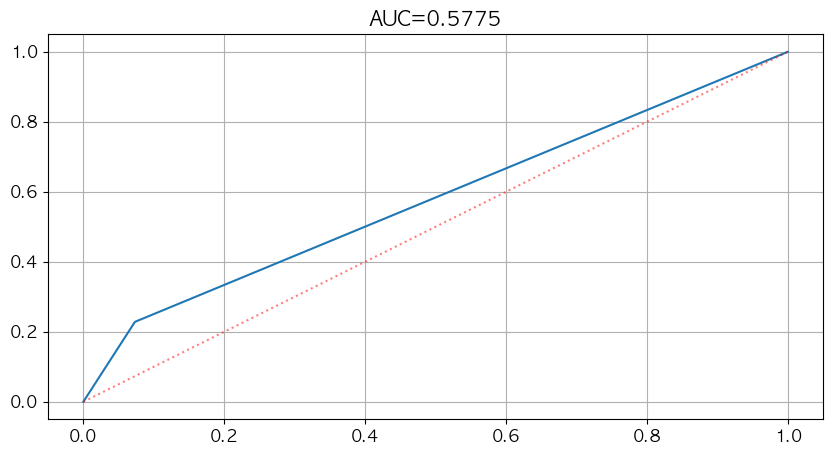

In [13]:
ras = roc_auc_score(df1['합격여부'], df1['예측결과'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(df1['합격여부'], df1['예측결과'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [16]:
# 정확도
acc = accuracy_score(df1['합격여부'], df1['예측결과'])

# 정밀도
pre = precision_score(df1['합격여부'], df1['예측결과'])

# 재현율
recall = recall_score(df1['합격여부'], df1['예측결과'])

# F1 score
f1 = f1_score(df1['합격여부'], df1['예측결과'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'설명력(Pseudo-Rsqe)': [fit.prsquared], '정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

# result_df.T
result_df

,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.081073,0.705,0.591837,0.228346,0.07326,0.92674,0.577543,0.329545


#### 오즈비(Odds Rate) 구하기
- 계수값들만 추출하기
- 독립변수의 `coef` : logit함수 계수. 해당 독립함수의 오즈에 $log$를 씌운 값 (자연로그)

In [18]:
coef = fit.params
coef

Intercept   -3.449549
필기점수         0.002294
학부성적         0.777014
병원경력        -0.560031
dtype: float64

- 오즈비 계산
    - 오즈비는 성공할 확률을 실패할 확률로 나눈 값이고 이 분석에서는 합격여부가 종속변수이므로 합격할 확률을 불합격할 확률로 나눈 값이다.
    - $\text{Odds Rate} = \frac{합격확률}{불합격확률}$
    - 계수값에 대해 `np.exp()` 함수를 적용하면 각각의 회귀계수들을 오즈값으로 변환할 수 있다.
    > 해당 독립변수가 종속변수에 미치는 영향을 더 직관적으로 확인할 수 있다. 학부성적이 종속변수인 합격여부에 끼치는 영향이 가장 크다고 볼 수 있다.

In [19]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate, columns=['odds_rate'])
odds_rate_df

,odds_rate
Intercept,0.031760
필기점수,1.002297
학부성적,2.174967
병원경력,0.571191


#### 가상의 데이터를 통한 합격 여부 예측

In [22]:
myinput = input("필기점수, 학부성적, 병원경력을 콤마(,)로 구분하여 입력하세요.\n예: 480,4.3,2")

if not myinput:
    myinput = "480,4.0,2"

myinput = myinput.split(',')
mydata = {'필기점수': int(myinput[0].strip()), '학부성적': float(myinput[1].strip()), '병원경력': int(myinput[2].strip())}
myresult = fit.predict(mydata)
myresult

0    0.410849
dtype: float64

In [23]:
"당신의 합격 확률은 {0:0.2f}% 입니다.".format(myresult[0]*100)

'당신의 합격 확률은 41.08% 입니다.'